In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import random
import math
%matplotlib inline

In [15]:
images_dir = "./images"
# list of all digits
digits = list(map(str, range(10))) + ["ba", "pa"]
# map digits to their respective directory path
digits_dir = dict(zip(digits, map(lambda d: os.path.join(images_dir, d), digits)))

In [16]:
total_images = sum(len(glob.glob(os.path.join(folder, "*.jpg"))) for _, folder in digits_dir.items())
total_images

2033

In [36]:
im_width = im_height = 128
batch_size = 32
validation_split = 0.3

datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             validation_split=validation_split,
                             shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=10, 
                             
                            )

train_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="training")
validation_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="validation")
train_steps_per_epoch = int(total_images * (1 - validation_split)) // batch_size
validation_steps_per_epoch = int(total_images * validation_split) // batch_size

Found 1430 images belonging to 12 classes.
Found 603 images belonging to 12 classes.


In [37]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Flatten
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_img = Input(shape=(im_height, im_width, 3))
_ = conv_block(input_img, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
_ = GlobalMaxPool2D()(_)
_ = Dense(units=128, activation="relu")(_)
_ = Dense(units=12, activation="softmax")(_)

model = Model(inputs=input_img, outputs=_)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_10 (Ba  (None, 124, 124, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 32)        9248

In [38]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=20, 
                              validation_data=validation_gen, validation_steps=validation_steps_per_epoch)

C:\Users\dell\AppData\Local\Temp\ipykernel_11928\740632642.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=20,


Epoch 1/20
28/28 [==============================] - 134s 5s/step - loss: 2.6947 - accuracy: 0.1051 - val_loss: 2.4801 - val_accuracy: 0.0867
Epoch 2/20
28/28 [==============================] - 119s 4s/step - loss: 2.3049 - accuracy: 0.2232 - val_loss: 2.4781 - val_accuracy: 0.1317
Epoch 3/20
28/28 [==============================] - 122s 4s/step - loss: 2.1107 - accuracy: 0.3064 - val_loss: 2.4699 - val_accuracy: 0.1167
Epoch 4/20
28/28 [==============================] - 123s 4s/step - loss: 1.8656 - accuracy: 0.4203 - val_loss: 2.4369 - val_accuracy: 0.1317
Epoch 5/20
28/28 [==============================] - 116s 4s/step - loss: 1.6347 - accuracy: 0.5036 - val_loss: 2.4098 - val_accuracy: 0.1450
Epoch 6/20
28/28 [==============================] - 108s 4s/step - loss: 1.4160 - accuracy: 0.5833 - val_loss: 2.4209 - val_accuracy: 0.1300
Epoch 7/20
28/28 [==============================] - 121s 4s/step - loss: 1.2437 - accuracy: 0.6413 - val_loss: 2.1557 - val_accuracy: 0.3283
Epoch 8/20
28

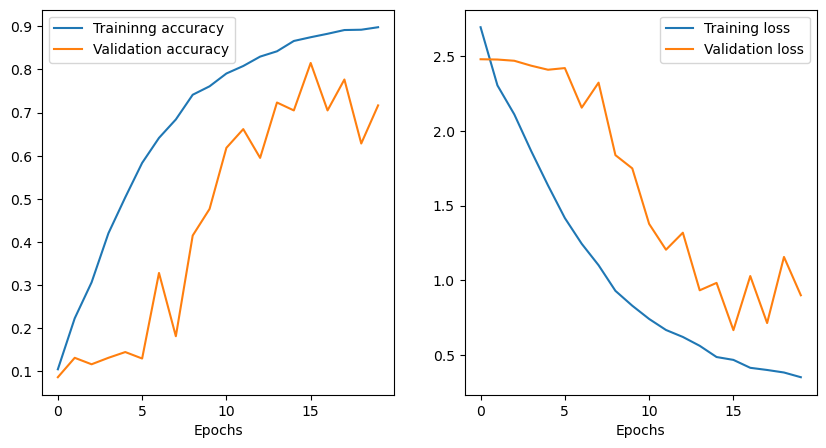

In [57]:
# model.save('number_plate_model2.h5')
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['accuracy'], label='Traininng accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

# Plot some predictions

In [34]:
# from tensorflow import keras
# model = keras.models.load_model('number_plate_model.h5')
X, Y_true = next(validation_gen)
Y_true = Y_true.argmax(axis=-1)
Y_pred = model.predict_on_batch(X).argmax(axis=-1)
validation_gen

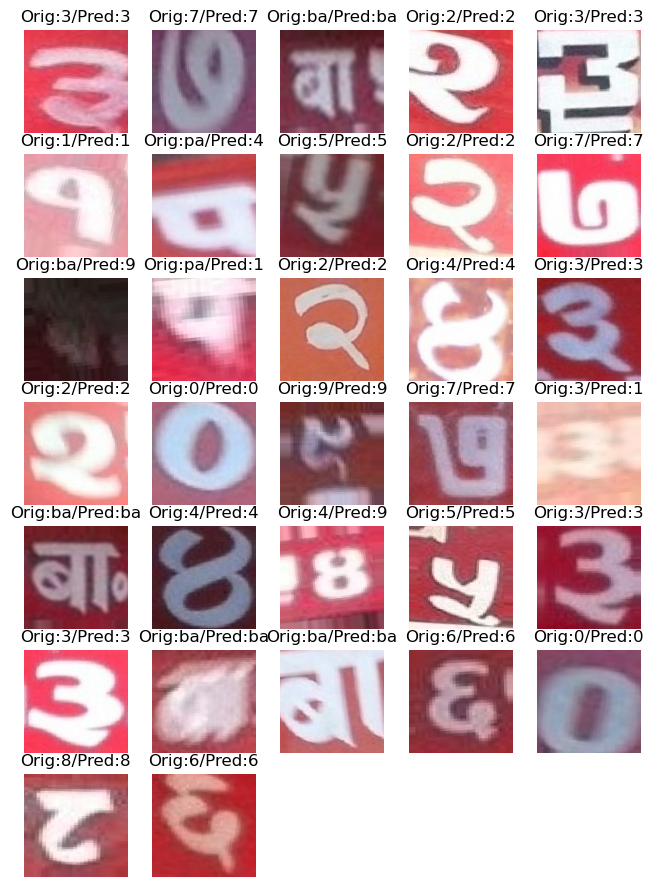

In [48]:
true_value = []
pred_value = []
n_cols = 5
n_rows = math.ceil(len(X) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols+3, n_rows+4))
for i, (x, y_true, y_pred) in enumerate(zip(X, Y_true, Y_pred)):
    ax = axes.flat[i]
    ax.imshow(x, aspect='equal')
    true_value.append(y_true)
    pred_value.append(y_pred)
    ax.set_title("Orig:{}/Pred:{}".format(digits[y_true], digits[y_pred]))

for ax in axes.flat:
    ax.axis('off')

In [49]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
confusion = confusion_matrix(true_value, pred_value)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0]
 [0 1 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 1 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 4 0]
 [0 1 0 0 1 0 0 0 0 0 0 0]]


# Model Evaluation

In [52]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred)

# Calculate True Positives (TP) for each class (diagonal elements)
TP = np.diag(confusion_matrix)

# Calculate False Positives (FP) for each class
FP = np.sum(confusion_matrix, axis=0) - TP

# Calculate False Negatives (FN) for each class
FN = np.sum(confusion_matrix, axis=1) - TP

# Calculate True Negatives (TN) for each class
total_samples = np.sum(confusion_matrix)
TN = total_samples - TP - FP - FN

# Calculate Precision, Recall (Sensitivity), and F1-Score for each class
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)


# # Print the results for each class
for class_idx in range(12):
    print(f"Class {class_idx + 1}:")
    print("True Positives (TP):", TP[class_idx])
    print("False Positives (FP):", FP[class_idx])
    print("False Negatives (FN):", FN[class_idx])
    print("True Negatives (TN):", TN[class_idx])
    print("Precision:", precision[class_idx])
    print("Recall (Sensitivity):", recall[class_idx])
    print("F1-Score:", f1_score[class_idx])


Class 1:
True Positives (TP): 2
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 30
Precision: 1.0
Recall (Sensitivity): 1.0
F1-Score: 1.0

Class 2:
True Positives (TP): 1
False Positives (FP): 2
False Negatives (FN): 0
True Negatives (TN): 29
Precision: 0.3333333333333333
Recall (Sensitivity): 1.0
F1-Score: 0.5

Class 3:
True Positives (TP): 4
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 28
Precision: 1.0
Recall (Sensitivity): 1.0
F1-Score: 1.0

Class 4:
True Positives (TP): 5
False Positives (FP): 0
False Negatives (FN): 1
True Negatives (TN): 26
Precision: 1.0
Recall (Sensitivity): 0.8333333333333334
F1-Score: 0.9090909090909091

Class 5:
True Positives (TP): 2
False Positives (FP): 1
False Negatives (FN): 1
True Negatives (TN): 28
Precision: 0.6666666666666666
Recall (Sensitivity): 0.6666666666666666
F1-Score: 0.6666666666666666

Class 6:
True Positives (TP): 2
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 30
Precis

C:\Users\dell\AppData\Local\Temp\ipykernel_11928\3770226659.py:19: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


In [56]:
FN

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2], dtype=int64)